# sport-image-classification

`This is trying to classified sport images into 100 different classes. `

In [1]:
!pip install jovian --upgrade --quiet

In [3]:
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Downloading the dataset from"https://www.kaggle.com/datasets/gpiosenka/sports-classification"

**Images were gathered from internet searches. The images were scanned with a duplicate image detector program I wrote. Any duplicate images were removed to prevent bleed through of images between the train, test and valid data sets. All images were then resized to 224 X224 X 3 and converted to jpg format. A csv file is included that for each image file contains the relative path to the image file, the image file class label and the dataset (train, test or valid) that the image file resides in. This is a clean dataset.**

In [5]:
dataset_url = 'https://www.kaggle.com/datasets/gpiosenka/sports-classification'

In [6]:
od.download(dataset_url)

100%|██████████| 424M/424M [00:25<00:00, 17.4MB/s]


In [7]:
data_dir = './sports-classification'

In [ ]:
os.listdir(data_dir)

['test',
 'EfficientNetB0-100-(224 X 224)- 98.40.h5',
 'valid',
 'sports.csv',
 'train']

In [8]:
train_dir = './sports-classification/train'

In [ ]:
for cls in os.listdir(train_dir):
    print(cls, ':', len(os.listdir(train_dir + '/' + cls)))

wheelchair racing : 119
barell racing : 123
jai alai : 132
billiards : 145
motorcycle racing : 132
figure skating women : 157
horse jumping : 134
figure skating pairs : 151
basketball : 169
hang gliding : 121
archery : 132
bungee jumping : 125
javelin : 136
sumo wrestling : 133
balance beam : 147
figure skating men : 128
track bicycle : 135
chuckwagon racing : 120
water polo : 130
rock climbing : 141
bobsled : 138
bowling : 120
croquet : 134
speed skating : 136
bmx : 140
pole vault : 138
high jump : 159
nascar racing : 189
frisbee : 131
baton twirling : 108
harness racing : 147
ice yachting : 112
pole climbing : 118
giant slalom : 150
polo : 157
roller derby : 163
snow boarding : 117
mushing : 111
rowing : 143
pommel horse : 120
rings : 157
fencing : 135
boxing : 116
shuffleboard : 130
cricket : 129
ski jumping : 130
hockey : 172
luge : 127
horse racing : 139
pole dancing : 112
axe throwing : 113
tennis : 131
disc golf : 123
ampute football : 112
baseball : 174
tug of war : 128
sky sur

# Import dataset using Pytorch

In [9]:
from torchvision.datasets import ImageFolder

In [10]:
train_dataset = ImageFolder(data_dir + '/train')
test_dataset = ImageFolder(data_dir + '/test')
valid_dataset = ImageFolder(data_dir + '/valid')

In [ ]:
len(train_dataset) , len(test_dataset) , len(valid_dataset)

(13492, 500, 500)

In [ ]:
train_dataset.classes

['air hockey',
 'ampute football',
 'archery',
 'arm wrestling',
 'axe throwing',
 'balance beam',
 'barell racing',
 'baseball',
 'basketball',
 'baton twirling',
 'bike polo',
 'billiards',
 'bmx',
 'bobsled',
 'bowling',
 'boxing',
 'bull riding',
 'bungee jumping',
 'canoe slamon',
 'cheerleading',
 'chuckwagon racing',
 'cricket',
 'croquet',
 'curling',
 'disc golf',
 'fencing',
 'field hockey',
 'figure skating men',
 'figure skating pairs',
 'figure skating women',
 'fly fishing',
 'football',
 'formula 1 racing',
 'frisbee',
 'gaga',
 'giant slalom',
 'golf',
 'hammer throw',
 'hang gliding',
 'harness racing',
 'high jump',
 'hockey',
 'horse jumping',
 'horse racing',
 'horseshoe pitching',
 'hurdles',
 'hydroplane racing',
 'ice climbing',
 'ice yachting',
 'jai alai',
 'javelin',
 'jousting',
 'judo',
 'lacrosse',
 'log rolling',
 'luge',
 'motorcycle racing',
 'mushing',
 'nascar racing',
 'olympic wrestling',
 'parallel bar',
 'pole climbing',
 'pole dancing',
 'pole vau

**The size of every image is 3x224x224**

In [ ]:
train_dataset[0]

(<PIL.Image.Image image mode=RGB size=224x224>, 0)

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

Label:1


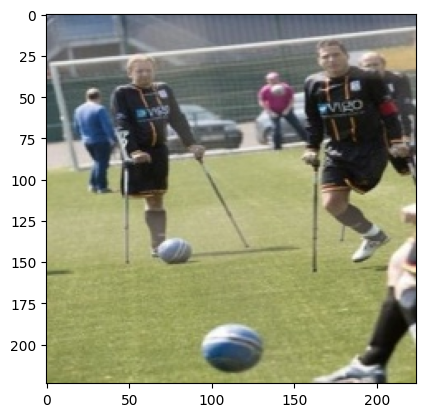

In [ ]:
img, label = train_dataset[120]
plt.imshow(img)
print(f'Label:{label}')

# Data transforms (normalization & data augmentation)

In [11]:
import torchvision.transforms as tt

In [12]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomHorizontalFlip(),
                         # tt.RandomRotate
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [13]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/valid', valid_tfms)
test_ds = ImageFolder(data_dir+'/test', test_tfms)

In [14]:
from torch.utils.data import DataLoader

In [15]:
batch_size = 64
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, pin_memory=True)
#test_dl = DataLoader(test_ds, batch_size, pin_memory=True)

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:40], nrow=10).permute(1, 2, 0).clamp(0,1))
        break

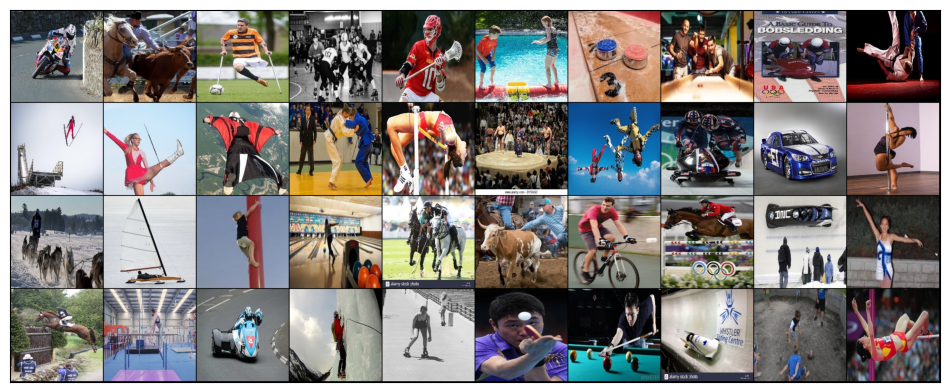

In [ ]:
show_batch(train_dl)

#Using a GPU

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
#test_dl = DeviceDataLoader(test_dl, device)

#Model and Training Utilties

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Model

In [20]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Sport_img_classification(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128),
                                  conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512),
                                  conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [21]:
model = to_device(Sport_img_classification(3, len(train_dataset.classes)), device)
model

Sport_img_classification(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2)

# Training

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 4.6110639572143555, 'val_acc': 0.009765625}]

In [ ]:
history += fit(25, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 4.5817, val_loss: 3.7969, val_acc: 0.1179
Epoch [1], train_loss: 3.7414, val_loss: 3.1948, val_acc: 0.2147
Epoch [2], train_loss: 3.2033, val_loss: 2.7845, val_acc: 0.3012
Epoch [3], train_loss: 2.8159, val_loss: 2.4711, val_acc: 0.3670
Epoch [4], train_loss: 2.4879, val_loss: 2.1990, val_acc: 0.4485
Epoch [5], train_loss: 2.2272, val_loss: 1.8714, val_acc: 0.5081
Epoch [6], train_loss: 2.0037, val_loss: 1.8491, val_acc: 0.5356
Epoch [7], train_loss: 1.8271, val_loss: 1.7079, val_acc: 0.5527
Epoch [8], train_loss: 1.6566, val_loss: 1.4922, val_acc: 0.6019
Epoch [9], train_loss: 1.5064, val_loss: 1.4653, val_acc: 0.6188
Epoch [10], train_loss: 1.3638, val_loss: 1.3229, val_acc: 0.6429
Epoch [11], train_loss: 1.2490, val_loss: 1.2361, val_acc: 0.6662
Epoch [12], train_loss: 1.1420, val_loss: 1.2443, val_acc: 0.6559
Epoch [13], train_loss: 1.0394, val_loss: 1.2564, val_acc: 0.6442
Epoch [14], train_loss: 0.9272, val_loss: 1.1207, val_acc: 0.6743
Epoch [15], train_lo

In [ ]:
history += fit(10, 0.001, model, train_dl, valid_dl)

Epoch [0], train_loss: 0.2206, val_loss: 0.7334, val_acc: 0.7987
Epoch [1], train_loss: 0.1819, val_loss: 0.7177, val_acc: 0.8021
Epoch [2], train_loss: 0.1803, val_loss: 0.6960, val_acc: 0.8065
Epoch [3], train_loss: 0.1701, val_loss: 0.6844, val_acc: 0.8114
Epoch [4], train_loss: 0.1700, val_loss: 0.6871, val_acc: 0.8095
Epoch [5], train_loss: 0.1668, val_loss: 0.6831, val_acc: 0.8119
Epoch [6], train_loss: 0.1682, val_loss: 0.6859, val_acc: 0.8045
Epoch [7], train_loss: 0.1610, val_loss: 0.6782, val_acc: 0.8163
Epoch [8], train_loss: 0.1618, val_loss: 0.6727, val_acc: 0.8182
Epoch [9], train_loss: 0.1621, val_loss: 0.6748, val_acc: 0.8245


In [ ]:
history += fit(15, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.1490, val_loss: 0.6871, val_acc: 0.8206
Epoch [1], train_loss: 0.1201, val_loss: 0.6665, val_acc: 0.8221
Epoch [2], train_loss: 0.1055, val_loss: 0.6870, val_acc: 0.8241
Epoch [3], train_loss: 0.0966, val_loss: 0.6696, val_acc: 0.8304
Epoch [4], train_loss: 0.0827, val_loss: 0.6901, val_acc: 0.8226
Epoch [5], train_loss: 0.0818, val_loss: 0.6605, val_acc: 0.8236
Epoch [6], train_loss: 0.0725, val_loss: 0.6534, val_acc: 0.8250
Epoch [7], train_loss: 0.0699, val_loss: 0.6713, val_acc: 0.8226
Epoch [8], train_loss: 0.0645, val_loss: 0.6826, val_acc: 0.8187
Epoch [9], train_loss: 0.0661, val_loss: 0.6933, val_acc: 0.8226
Epoch [10], train_loss: 0.0558, val_loss: 0.6970, val_acc: 0.8304
Epoch [11], train_loss: 0.0559, val_loss: 0.7044, val_acc: 0.8158
Epoch [12], train_loss: 0.0574, val_loss: 0.6918, val_acc: 0.8206
Epoch [13], train_loss: 0.0501, val_loss: 0.6924, val_acc: 0.8241
Epoch [14], train_loss: 0.0474, val_loss: 0.7041, val_acc: 0.8217


In [ ]:
torch.save(model.state_dict(), 'sport_image_classification.pth')

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

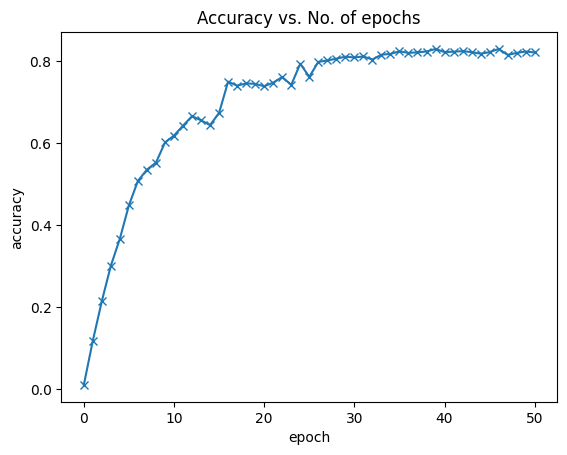

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bo')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

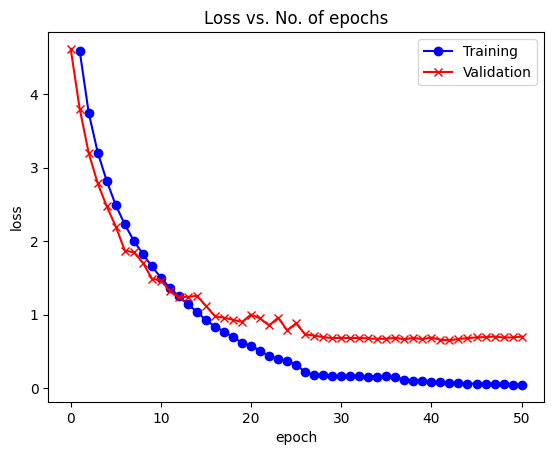

In [ ]:
plot_losses(history)

**Based on the plot_losses graph, it becomes evident that beyond epoch 30, there is minimal variation in the value of Val_loss.**

# Using pre-trained model

In [ ]:
import torchvision.models as models

In [ ]:
class Sport_img_classification_2(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained VGG16 model
        self.network = models.vgg16(pretrained=True)

        # Replace the last fully connected layer (classifier)
        num_ftrs = self.network.classifier[6].in_features
        self.network.classifier[6] = nn.Linear(num_ftrs, 100)

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [ ]:
model_2 = to_device(Sport_img_classification_2(), device)
model_2

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sport_img_classification_2(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inpla

In [ ]:
history = [evaluate(model_2, valid_dl)]
history

[{'val_loss': 4.611520290374756, 'val_acc': 0.00390625}]

In [ ]:
history += fit(30, 0.001, model_2, train_dl, valid_dl)

Epoch [0], train_loss: 4.5793, val_loss: 4.5344, val_acc: 0.0443
Epoch [1], train_loss: 4.4854, val_loss: 4.3962, val_acc: 0.1535
Epoch [2], train_loss: 4.3401, val_loss: 4.1889, val_acc: 0.2788
Epoch [3], train_loss: 4.1832, val_loss: 3.9944, val_acc: 0.3822
Epoch [4], train_loss: 4.0532, val_loss: 3.8847, val_acc: 0.5030
Epoch [5], train_loss: 3.9776, val_loss: 3.8372, val_acc: 0.5699
Epoch [6], train_loss: 3.9259, val_loss: 3.8099, val_acc: 0.6137
Epoch [7], train_loss: 3.8890, val_loss: 3.7884, val_acc: 0.6596
Epoch [8], train_loss: 3.8700, val_loss: 3.7785, val_acc: 0.6654
Epoch [9], train_loss: 3.8487, val_loss: 3.7662, val_acc: 0.6717
Epoch [10], train_loss: 3.8334, val_loss: 3.7538, val_acc: 0.7079
Epoch [11], train_loss: 3.8200, val_loss: 3.7494, val_acc: 0.7049
Epoch [12], train_loss: 3.8104, val_loss: 3.7448, val_acc: 0.7138
Epoch [13], train_loss: 3.8002, val_loss: 3.7387, val_acc: 0.7142
Epoch [14], train_loss: 3.7920, val_loss: 3.7356, val_acc: 0.7269
Epoch [15], train_lo

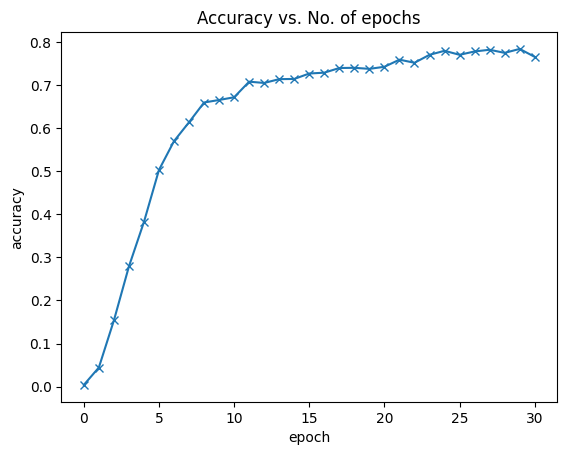

In [ ]:
plot_accuracies(history)

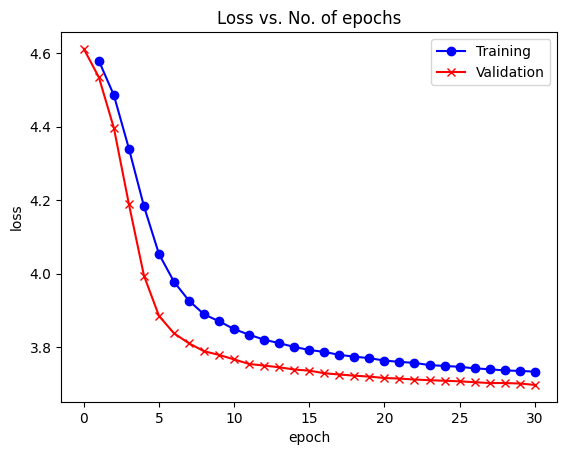

In [ ]:
plot_losses(history)

In [ ]:
torch.save(model_2.state_dict(), 'sport_image_classification_2.pth')

# loading model

In [22]:
model.load_state_dict(torch.load('/content/sport_image_classification.pth'))

<All keys matched successfully>

# Testing

# Get predictions for all of our test data.

In [23]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_ds.classes[preds[0].item()]

Label: air hockey , Predicted: air hockey


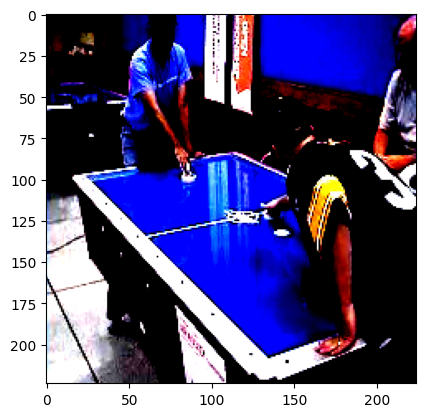

In [42]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

In [43]:
jovian.log_metrics(val_loss=0.8217,
                   val_acc=0.7041,
                   train_loss=0.0474)

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ··········
[jovian] Metrics logged.


# Reference:
- **Dataset**: https://www.kaggle.com/datasets/gpiosenka/sports-classification
- https://jovian.com/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-4-image-classification-with-cnn
- https://jovian.com/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-5-data-augmentation-regularization-and-resnets
- https://www.youtube.com/watch?v=MQGHl3E8QA0&t=637s

**Future work**
- Using other pre-trained model like `ResNet-18, ResNet-34, ResNet-50, ResNet-101, and ResNet-152, where the number indicates the depth of the network.`
- defining nn model with different hidden layers, kernel_size, MaxPool, etc.
- defining LeakyReLU instead of ReLU as the activation layer.